In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scripts.analysis as a
from scipy import stats

# Model Results and Comparisons

This notebook is used to analyze the results from the models. More information can be found in the paper that was published alongside this repository.

### 1. Load the Data

Change the directory to analyze different results from different runs. If you run the main python file you can do this using the file path returned from `run_analysis` however there may not be enough buildings with valuable data to view the visualizations properly. This pipeline should be used with the `example_results_from_paper.csv` or with a larger dataset inputed by the user and run with `main.ipynb`.

In [2]:
# Change this directory to analyze different results from different runs.
data_file = 'data/example_results_from_paper.csv'
summary_df = pd.read_csv(data_file)
summary_df.head()

,Unnamed: 0,balance_RK,balance_p_value,balance_rvalue,balance_stderr,decay_RC_cost,decay_RC_mean,decay_RC_median,decay_RC_std,decay_amnt,...,euler_RC_min_cost,euler_RC_std,euler_RK_mean,euler_RK_median,euler_RK_min_cost,euler_RK_std,euler_cost,euler_cost_mean,euler_test_cost,filename
0,2386,87.281164,4.976820e-03,-0.664600,0.003443,72.111941,144.090784,145.947075,12.227359,6.0,...,213.367131,43.893827,132.608241,135.354076,145.782312,17.131350,9.657444,8.113491,NaN,75409660ae4d8299ec17cff6db6caa5d0f49ce1f.csv
1,1657,16.056495,4.917681e-09,-0.806579,0.007946,NaN,NaN,NaN,NaN,NaN,...,170.538736,27.568648,29.544587,29.544587,23.706250,8.256655,0.354501,10.785408,NaN,94116c54100c3ed4b238630c896acc0c59e39f89.csv
2,752,54.002055,7.883772e-12,-0.844013,0.001909,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2e3fca3ae24aef951725320b078942f76efea10a.csv
3,809,99.597620,1.003481e-09,-0.793661,0.001248,NaN,NaN,NaN,NaN,NaN,...,177.361132,38.387458,97.684620,94.627298,105.823158,10.879223,8.061681,4.087325,NaN,6b06804cd3a222b27ad1ab610edfb644d67b0ddb.csv
4,970,61.288988,4.858406e-06,-0.653394,0.003067,55.654252,90.472921,90.472921,NaN,1.0,...,120.412519,32.020524,60.306393,58.445157,59.516262,8.311067,37.094145,15.652986,NaN,b821daa291d5b7d60e1560dc8d4728292a5211f2.csv


### 2. Remove instances where the models did not perform well

Remove the buildings for which the models couldn't obtain good results. To see the results without outliers removed, comment out these lines of code.

In [3]:
## === REMOVE OUTLIERS ACCORDING TO STD AND FITTING ERROR
summary_df = summary_df[summary_df['euler_RC_std'] < (1000/12)]
summary_df = summary_df[summary_df['balance_stderr'] < 0.009]
summary_df = summary_df[summary_df['euler_cost_mean'] < 25]
summary_df = summary_df[summary_df['balance_p_value'] < 0.05]

summary_df.head()

,Unnamed: 0,balance_RK,balance_p_value,balance_rvalue,balance_stderr,decay_RC_cost,decay_RC_mean,decay_RC_median,decay_RC_std,decay_amnt,...,euler_RC_min_cost,euler_RC_std,euler_RK_mean,euler_RK_median,euler_RK_min_cost,euler_RK_std,euler_cost,euler_cost_mean,euler_test_cost,filename
0,2386,87.281164,4.976820e-03,-0.664600,0.003443,72.111941,144.090784,145.947075,12.227359,6.0,...,213.367131,43.893827,132.608241,135.354076,145.782312,17.131350,9.657444,8.113491,NaN,75409660ae4d8299ec17cff6db6caa5d0f49ce1f.csv
1,1657,16.056495,4.917681e-09,-0.806579,0.007946,NaN,NaN,NaN,NaN,NaN,...,170.538736,27.568648,29.544587,29.544587,23.706250,8.256655,0.354501,10.785408,NaN,94116c54100c3ed4b238630c896acc0c59e39f89.csv
3,809,99.597620,1.003481e-09,-0.793661,0.001248,NaN,NaN,NaN,NaN,NaN,...,177.361132,38.387458,97.684620,94.627298,105.823158,10.879223,8.061681,4.087325,NaN,6b06804cd3a222b27ad1ab610edfb644d67b0ddb.csv
4,970,61.288988,4.858406e-06,-0.653394,0.003067,55.654252,90.472921,90.472921,NaN,1.0,...,120.412519,32.020524,60.306393,58.445157,59.516262,8.311067,37.094145,15.652986,NaN,b821daa291d5b7d60e1560dc8d4728292a5211f2.csv
6,2391,84.128929,3.646549e-04,-0.763233,0.002598,39.833612,86.830976,85.295013,3.084147,3.0,...,146.002748,24.759578,112.082269,112.009144,115.855861,10.425146,11.951722,5.100931,NaN,0d8bf72fa682621b7a31acb63a4257c9d5db9de6.csv


### 3. Visualize the Performance of the decay curve method 

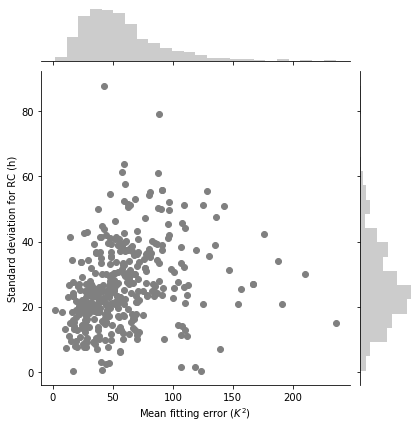

In [4]:
g = sns.jointplot(
    x="decay_RC_cost", 
    y="decay_RC_std", 
    data=summary_df, 
    color='grey',
);
g.set_axis_labels(
    xlabel='Mean fitting error ($K^2$)', 
    ylabel='Standard deviation for RC (h)'
);

### 4. Visualize Performance of the Energy Balance Method

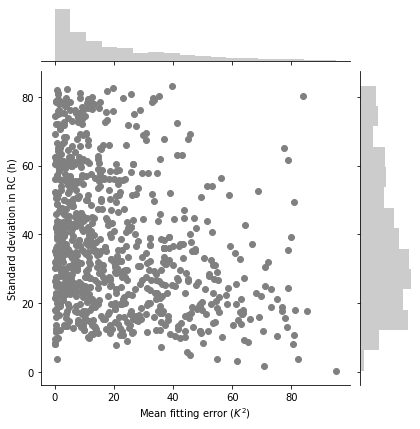

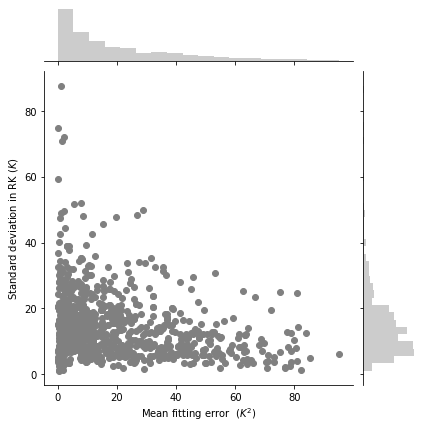

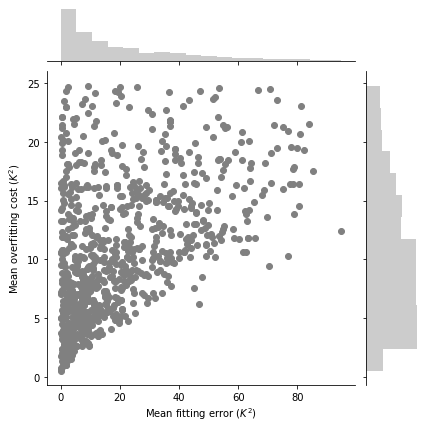

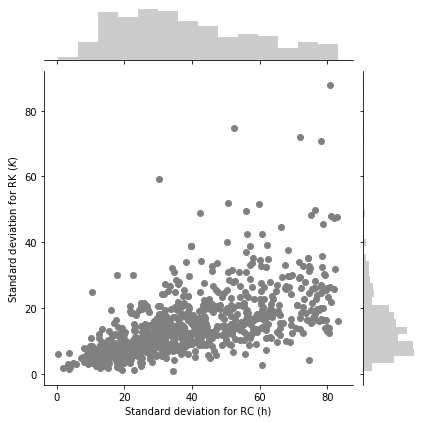

In [5]:
g = sns.jointplot(
    x="euler_cost", 
    y="euler_RC_std", 
    data=summary_df, 
    color='grey',
);
g.set_axis_labels(
    xlabel='Mean fitting error ($K^2$)', 
    ylabel='Standard deviation in RC (h)'
);

# =======================
g = sns.jointplot(
    x="euler_cost", 
    y="euler_RK_std", 
    data=summary_df,
    color='grey',
);
g.set_axis_labels(
    xlabel='Mean fitting error  ($K^2$)',
    ylabel='Standard deviation in RK ($K$)'
);

# ========================
g = sns.jointplot(
    x="euler_cost", 
    y="euler_cost_mean", 
    data=summary_df, 
    color='grey',
);
g.set_axis_labels(
    xlabel='Mean fitting error ($K^2$)', 
    ylabel='Mean overfitting cost ($K^2$)'
);

# ========================
g = sns.jointplot(
    x="euler_RC_std", 
    y="euler_RK_std", 
    data=summary_df, 
    color='grey',
);
g.set_axis_labels(
    xlabel='Standard deviation for RC (h)', 
    ylabel='Standard deviation for RK ($K$)'
);

### 5. Compare the results from the models

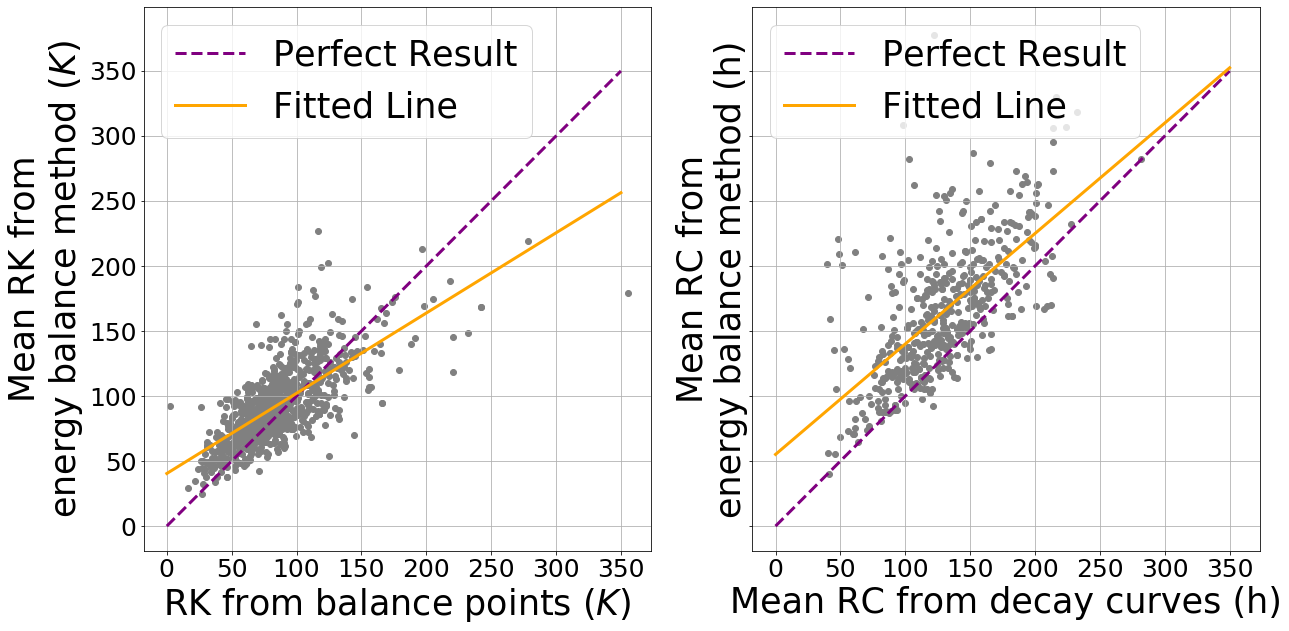

In [6]:
fix, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)

for tick in axes[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
for tick in axes[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
for tick in axes[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

def plot_ax(ax, x_val, y_val, x_axis, y_axis, title, x_lim=None, y_lim=None, 
            xlabel_size=35, ylabel_size=35):
    mask = ~np.isnan(x_val) & ~np.isnan(y_val)
    line = stats.linregress(x_val[mask], y_val[mask])
    slope, intercept, r_value, p_value, std_err = line
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax.scatter(x_val, y_val, marker='o', color='grey')
    x = np.linspace(0, 350, 1000)
    ax.plot(x, x, color='purple', label='Perfect Result',  ls='dashed', linewidth=3)
    ax.set_xlabel(x_axis, fontsize=xlabel_size)
    ax.set_ylabel(y_axis, fontsize=ylabel_size)
    if x_lim:
        plt.xlim(x_lim[0], x_lim[1])

    if y_lim:
        plt.ylim(y_lim[0], y_lim[1])
    ax.plot(x, intercept + slope*x, 'orange', label='Fitted Line', linewidth=3)
    ax.grid()
    ax.legend(fontsize=xlabel_size)

    
plot_ax(
    ax=axes[0],
    x_val=summary_df['balance_RK'], 
    y_val=summary_df['euler_RK_mean'],
    x_axis='RK from balance points ($K$)',
    y_axis='Mean RK from\nenergy balance method ($K$)',
    title='RK: FONI vs. Balance Point',
)

plot_ax(
    ax=axes[1],
    x_val=summary_df['decay_RC_mean'], 
    y_val=summary_df['euler_RC_mean'],
    x_axis='Mean RC from decay curves (h)',
    y_axis='Mean RC from\nenergy balance method (h)',
    title='RC: FONI Method vs. Decay Curves',
)
plt.show()

### 6. Compare Population Means

In [7]:
new_df = summary_df[['euler_RC_mean', 'decay_RC_mean']].dropna()
print(stats.ttest_ind(new_df['euler_RC_mean'],new_df['decay_RC_mean'], equal_var=False))
print(stats.ttest_ind(summary_df['euler_RK_mean'],summary_df['balance_RK'], equal_var=False))

Ttest_indResult(statistic=12.377148392681041, pvalue=1.3465838794886169e-32)
Ttest_indResult(statistic=5.1874549317647025, pvalue=2.384582647380562e-07)


### 7. Compare the Standard Deviations and Model Fitting Errors

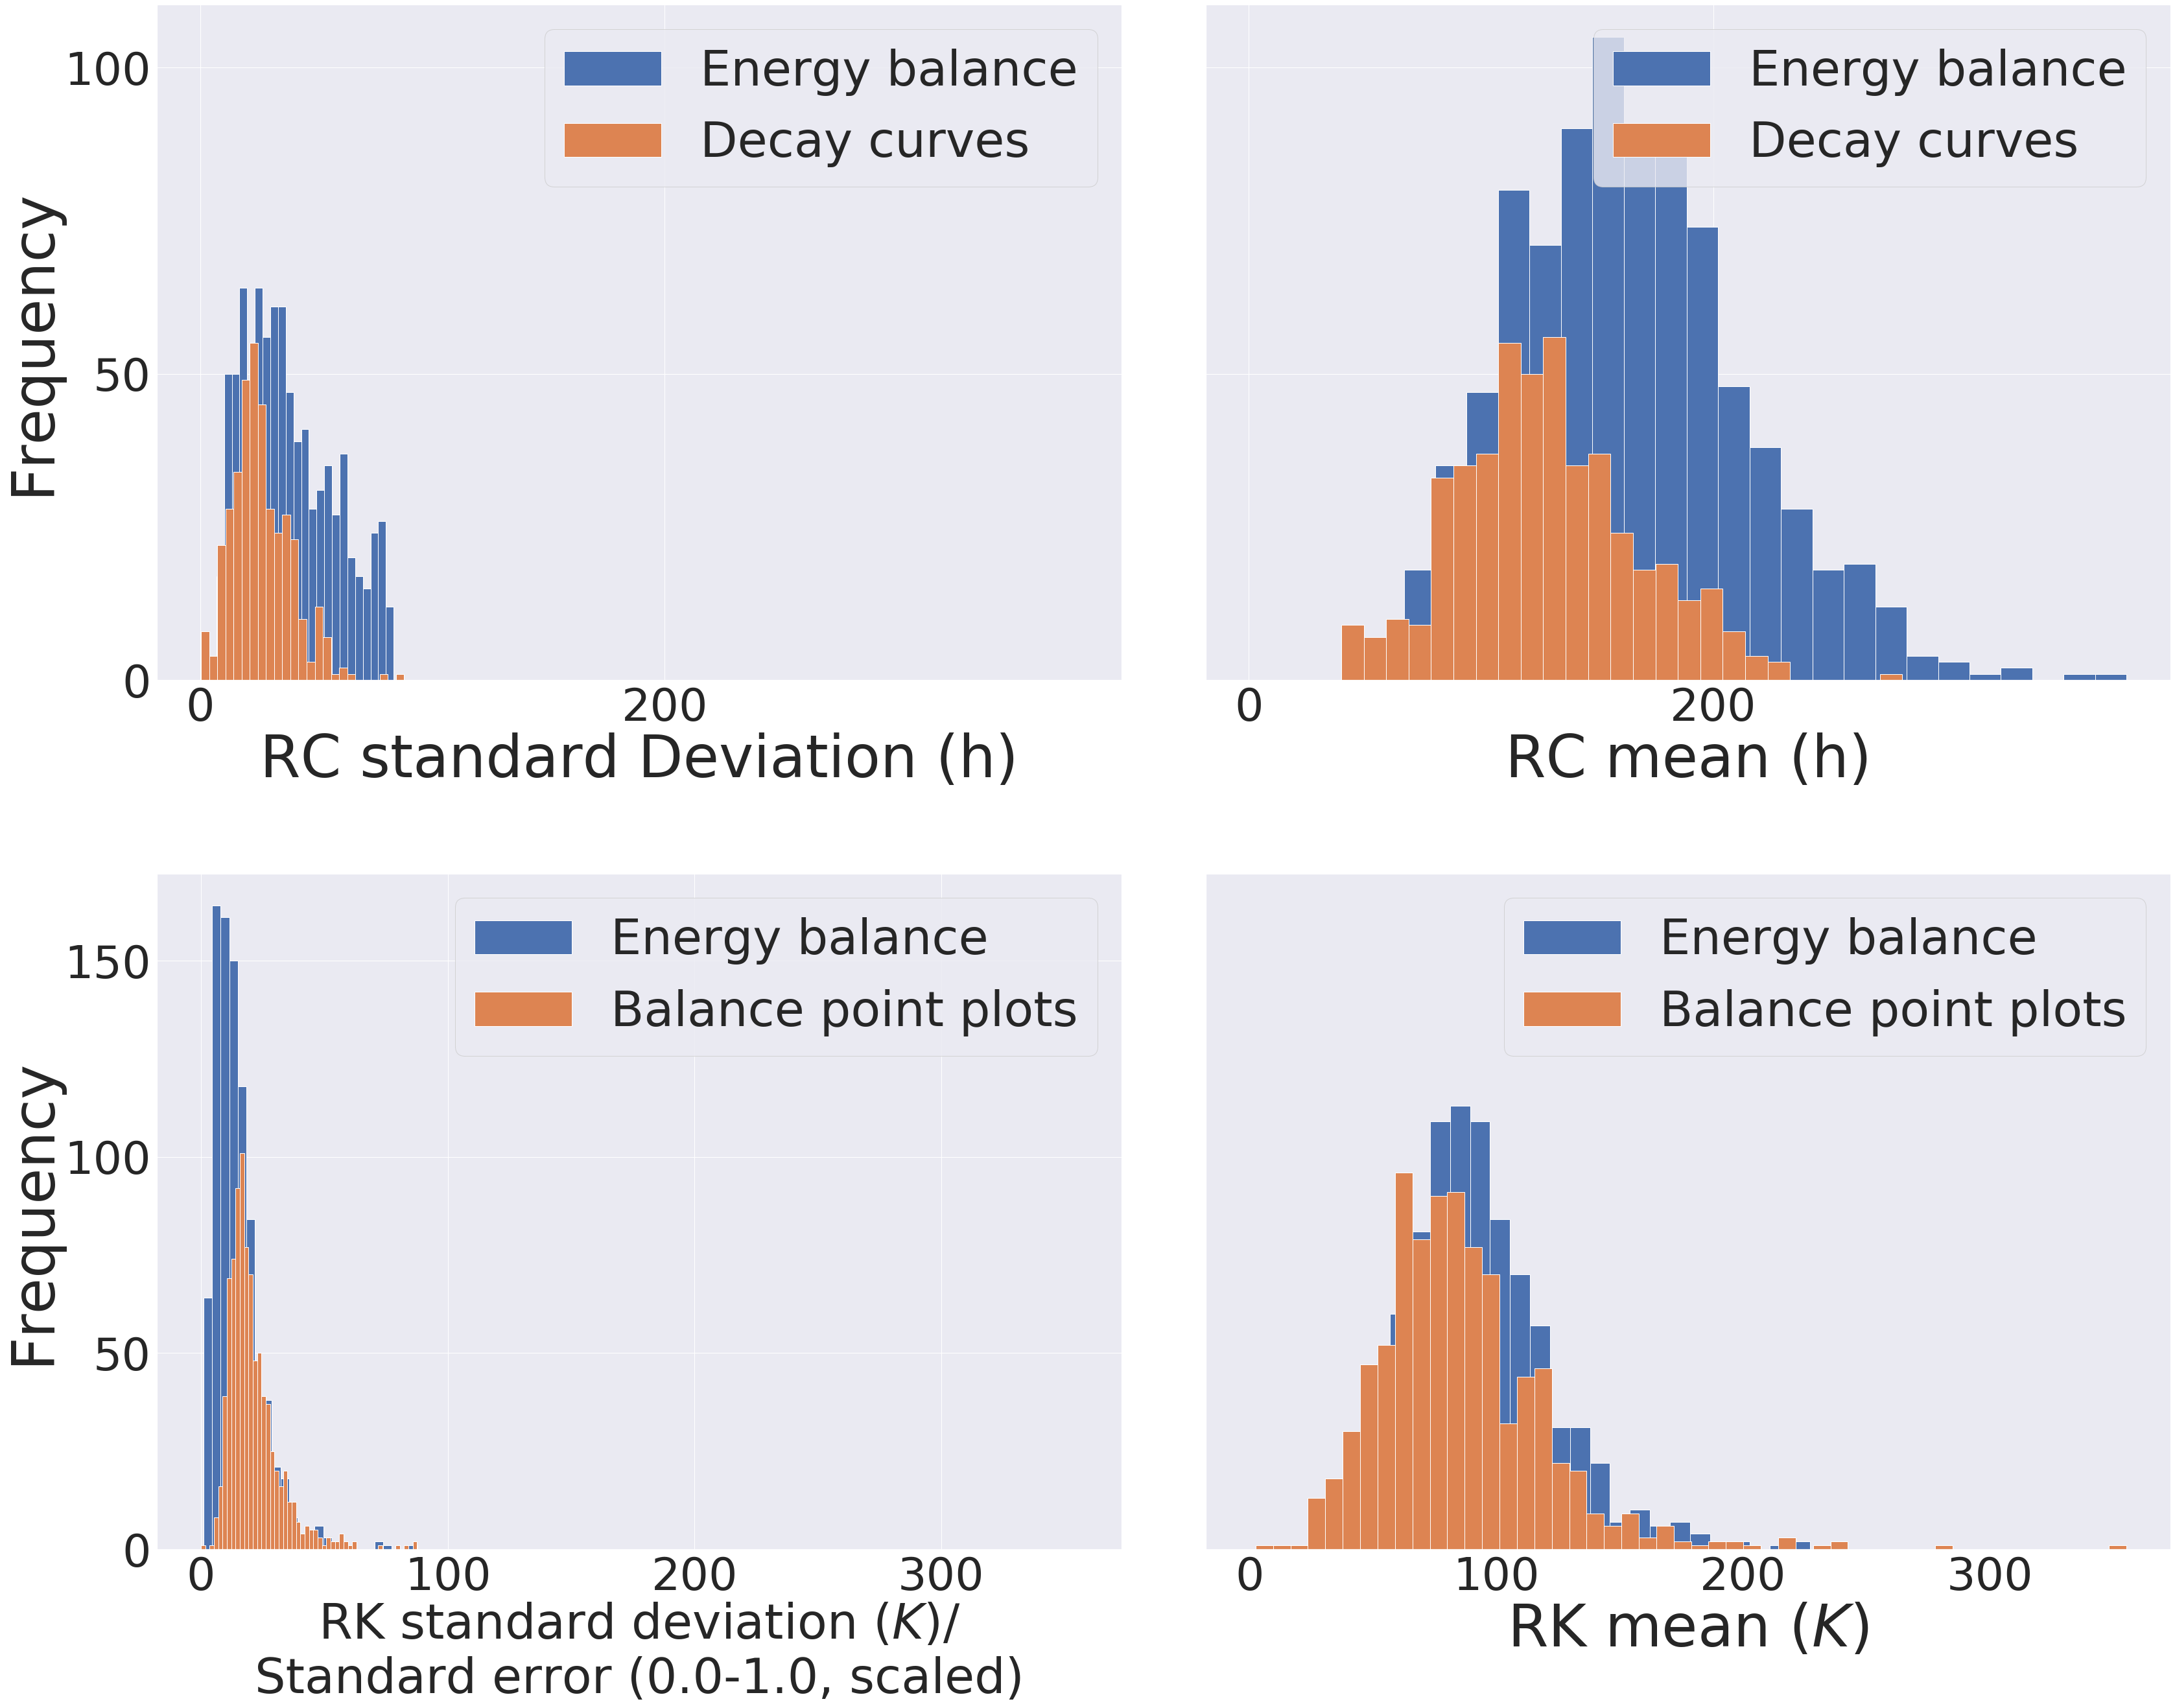

In [8]:
sns.set(font_scale=10)
fig, axes = plt.subplots(2, 2, figsize=(50, 40),
                          sharey='row', sharex='row')
first = axes[0,0]
second = axes[0,1]
third = axes[1,0]
fourth = axes[1,1]

labelsize=70
axislabelsize=90
legenfontsize=75

first.set_ylabel('Frequency', fontsize=axislabelsize)
first.set_xlabel('RC standard Deviation (h)', fontsize=axislabelsize)
second.set_xlabel('RC mean (h)', fontsize=axislabelsize)

# =================== Plot the first row, RC
for tick in first.yaxis.get_major_ticks():
    tick.label.set_fontsize(labelsize) 
    
for tick in first.xaxis.get_major_ticks():
    tick.label.set_fontsize(labelsize)
    
for tick in second.xaxis.get_major_ticks():
    tick.label.set_fontsize(labelsize) 
    
summary_df['euler_RC_std'].hist(bins=25, ax=first)
summary_df['decay_RC_std'].hist(bins=25, ax=first)
first.legend(['Energy balance', 'Decay curves'], prop={'size': legenfontsize})


summary_df['euler_RC_mean'].hist(bins=25, ax=second)
summary_df['decay_RC_mean'].hist(bins=25, ax=second)
second.legend(['Energy balance', 'Decay curves'], prop={'size': legenfontsize})


# ===================== Plot the second row, RK
third.set_ylabel('Frequency', fontsize=axislabelsize)
third.set_xlabel('RK standard deviation ($K$)/\nStandard error (0.0-1.0, scaled)', fontsize=legenfontsize)
fourth.set_xlabel('RK mean ($K$)', fontsize=axislabelsize)

for tick in third.yaxis.get_major_ticks():
    tick.label.set_fontsize(labelsize) 
    
for tick in third.xaxis.get_major_ticks():
    tick.label.set_fontsize(labelsize)
    
for tick in fourth.xaxis.get_major_ticks():
    tick.label.set_fontsize(labelsize) 

summary_df['balance_stderr_mult'] = summary_df['balance_stderr'] * 10000  

summary_df['euler_RK_std'].hist(bins=25, ax=third)
summary_df['balance_stderr_mult'].hist(bins=50, ax=third)
third.legend(['Energy balance', 'Balance point plots'], prop={'size': legenfontsize})

summary_df['euler_RK_mean'].hist(bins=25, ax=fourth)
summary_df['balance_RK'].hist(bins=50, ax=fourth)
fourth.legend(['Energy balance', 'Balance point plots'], prop={'size': legenfontsize})

plt.grid()
plt.tight_layout()
plt.show()

### 8. Find the proportionate difference in results

Text(0, 0.5, 'Difference between the models (%)')

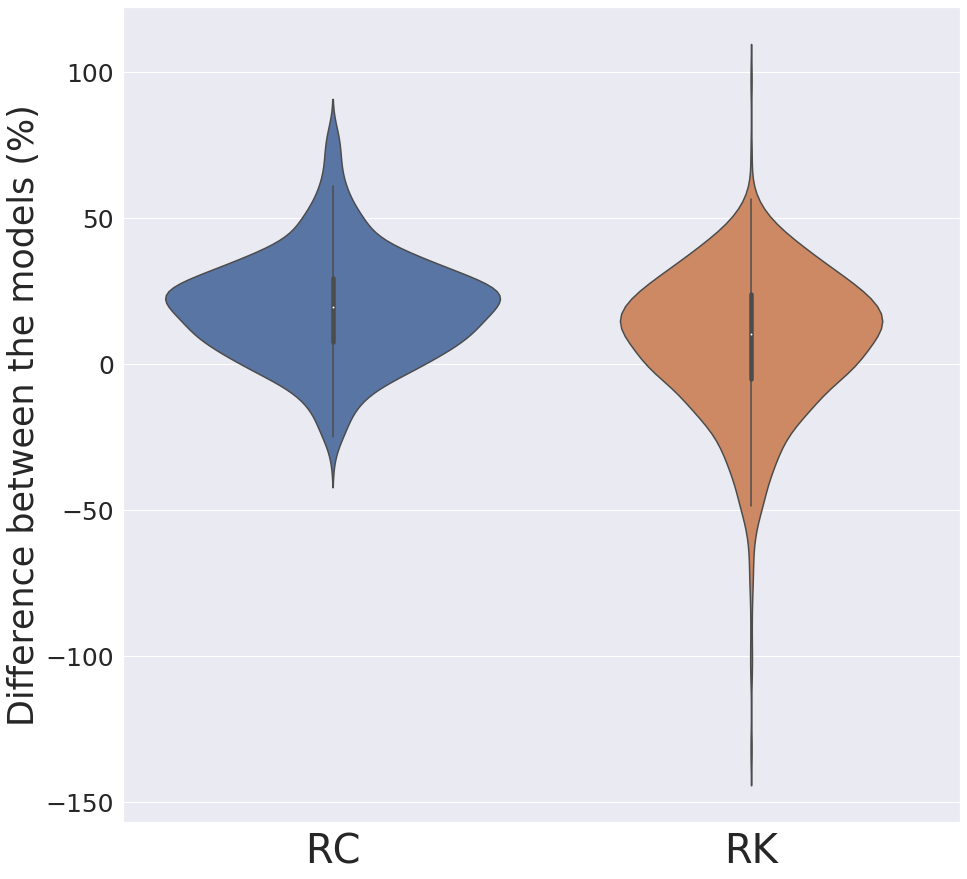

In [9]:
summary_df['RC_diffs'] = ((summary_df['euler_RC_mean'] - summary_df['decay_RC_mean']) / summary_df['euler_RC_mean']) * 100
summary_df['RK_diffs'] = ((summary_df['euler_RK_mean'] - summary_df['balance_RK']) / summary_df['euler_RK_mean']) * 100

plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.violinplot(
    data=summary_df[['RC_diffs', 'RK_diffs']],
)

plt.xticks([0, 1], ['RC', 'RK'], fontsize=40);
plt.yticks(fontsize=25);
plt.ylabel('Difference between the models (%)', fontsize=35)

### 9. Show the amount of decay curves that were found for each building

Text(0, 0.5, 'Frequency')

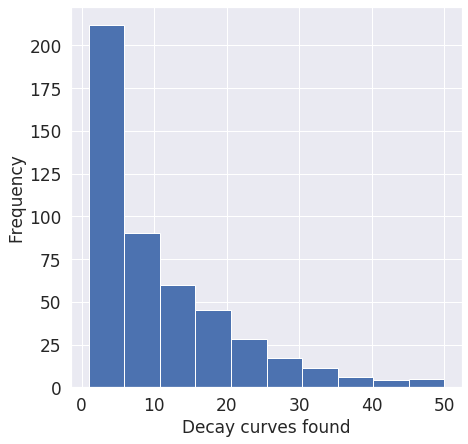

In [10]:
summary_df['decay_amnt'].plot(
    kind='hist', figsize=(7,7), grid=True, fontsize=17)
plt.xlabel('Decay curves found', fontsize=17)
plt.ylabel('Frequency', fontsize=17)

### 10. Correlate with the metadata

The code is here for reference but the full metadata was not released for privacy reasons

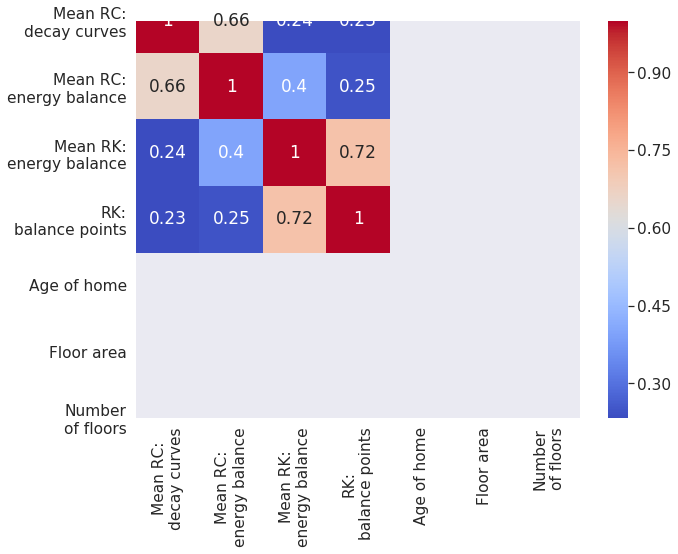

In [11]:
_, _, _, metadata_file, _ = a.get_paths(data_file)
metadata_df = pd.read_csv(metadata_file)

corr_vals = [
    'decay_RC_mean', 
    'euler_RC_mean',
    'euler_RK_mean',
    'balance_RK',
    'Age of Home [years]',
    'Floor Area [ft2]',
    'Number of Floors',
]

val_names = [
    'Mean RC:\ndecay curves',
    'Mean RC:\nenergy balance',
    'Mean RK:\nenergy balance',
    'RK:\nbalance points',
    'Age of home',
    'Floor area',
    'Number\nof floors'
]

size = 'Floor Area [ft2]'
age = 'Age of Home [years]'

join_df = summary_df.join(metadata_df.set_index('filename'), on='filename')
join_df['euler_R'] = join_df['euler_RK_mean'] / join_df[size]

# TODO
join_df['area_per_floor'] = join_df[size] / join_df['Number of Floors']

def plot_corr(df, size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    plt.figure(figsize=(10,8))
    corr = df.corr()
    sns.set(font_scale=1.4)
    sns.heatmap(
        corr, 
        cmap="coolwarm",
        annot=True,
        xticklabels=val_names,
        yticklabels=val_names,
        annot_kws={"size": 17}
    )
    plt.tight_layout()

plot_corr(join_df[corr_vals])